<a href="https://colab.research.google.com/github/danpele/2024-XAI-Intro/blob/main/RNNvsGRUvsLSTM/20250504%20HouseholdElecricityConsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import SimpleRNN, GRU, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [ ]:
import requests
import zipfile
import io
import pandas as pd

# Step 1: Download and extract the dataset
url = 'https://github.com/QuantLet/DeepLearning/blob/master/RNNvsGRUvsLSTM/household_power_consumption.txt.zip?raw=true'
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
zip_file.extractall()  # Extracts to the current working directory

# Step 2: Load the electricity consumption dataset
def load_electricity_data(location):
    df = pd.read_csv(location, sep=';', parse_dates={'datetime': ['Date', 'Time']},
                     infer_datetime_format=True,
                     low_memory=False, na_values=['nan', '?'])

    # Keep relevant columns and drop missing values
    df = df[['datetime', 'Global_active_power', 'Global_reactive_power', 'Voltage',
             'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].dropna()

    # Set the datetime as the index
    df.set_index('datetime', inplace=True)
    return df

# Load dataset
df = load_electricity_data('household_power_consumption.txt')

<ipython-input-15-a68fd7a08b66>:14: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(location, sep=';', parse_dates={'datetime': ['Date', 'Time']},
<ipython-input-15-a68fd7a08b66>:14: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(location, sep=';', parse_dates={'datetime': ['Date', 'Time']},
<ipython-input-15-a68fd7a08b66>:14: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(location, sep=';', parse_dates={'datetime': ['Date', 'Time']},


In [ ]:
# Step 2: Convert the data into a usable format
# Convert columns to numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Resample to hourly frequency and fill missing values
df = df.resample('H').mean().fillna(method='ffill')

<ipython-input-16-bcca268116a8>:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').mean().fillna(method='ffill')
<ipython-input-16-bcca268116a8>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.resample('H').mean().fillna(method='ffill')


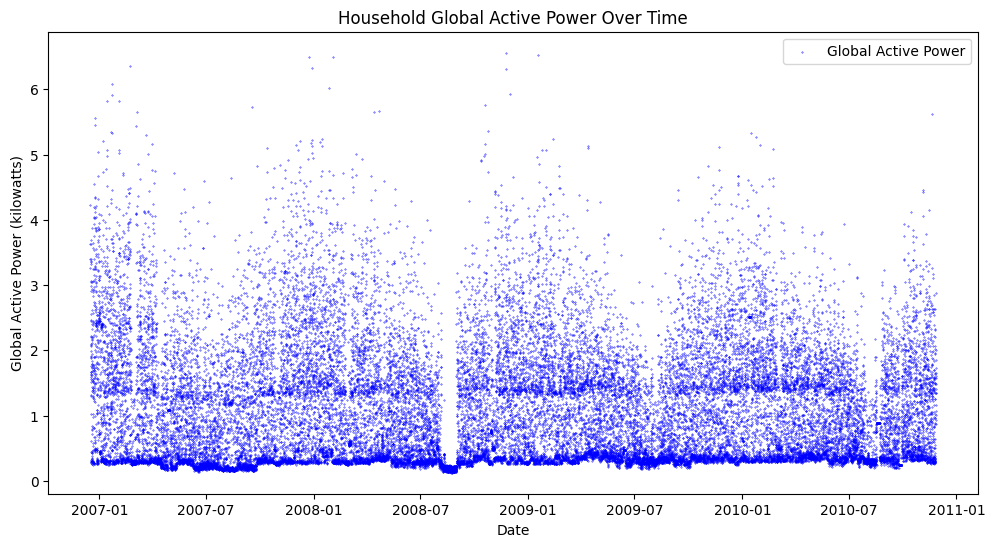

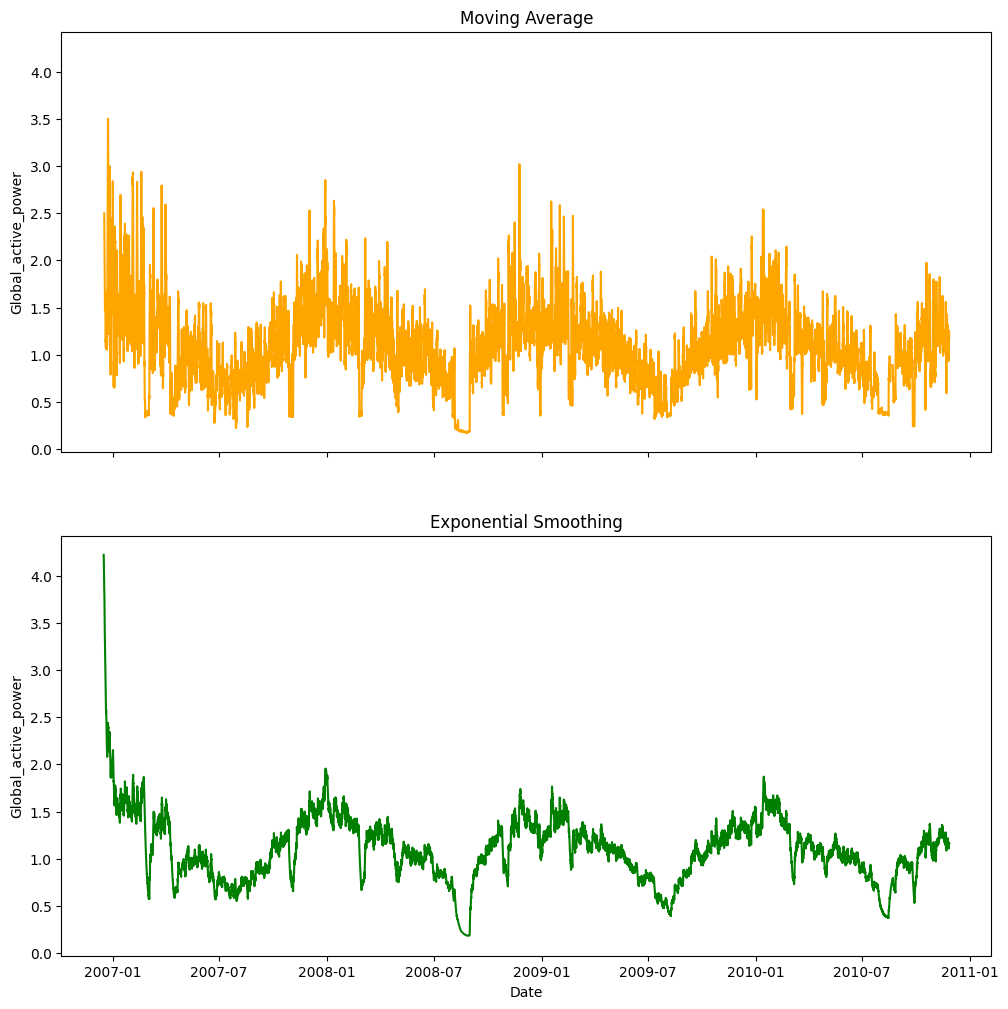

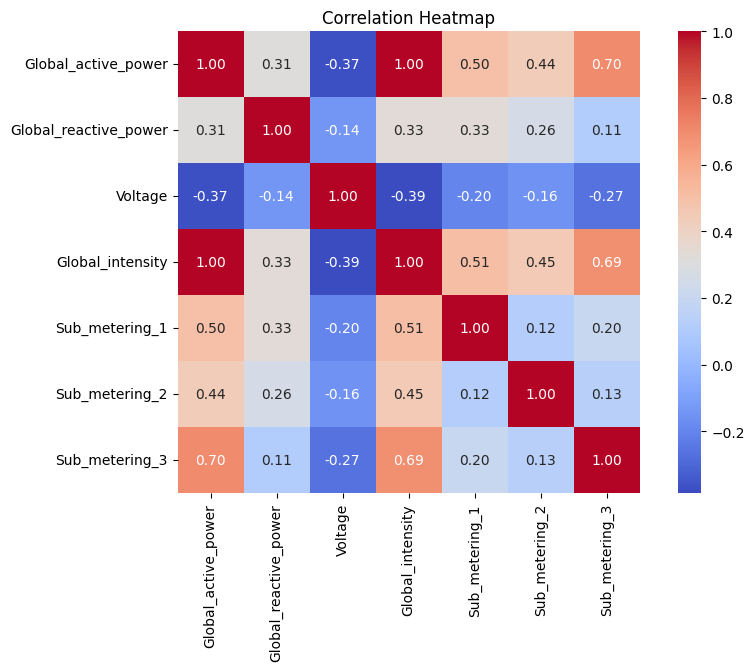

In [ ]:
# Step 3: Perform Exploratory Data Analysis (EDA)

# Scatter plot showing the seasonal pattern
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Global_active_power'], label='Global Active Power', color='blue', s=0.1)
plt.title('Household Global Active Power Over Time')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()


# Smoothening the data to see seasonal patters.
# Function for moving average smoothing
def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()

# Function for exponential smoothing
def exponential_smoothing(data, alpha):
    return data.ewm(alpha=alpha, adjust=False).mean()

# Play around with index ranges and smoothening parameters to see differrent seasonal patterns
test_df = df.copy().iloc[:,:]
test_df = test_df.drop(['Global_reactive_power', 'Voltage',
             'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'], axis=1)

# Smooth the data using different methods
window_size = 24  # For moving average
alpha = 0.01      # For exponential smoothing

test_df['moving_avg'] = moving_average(test_df['Global_active_power'], window_size)
test_df['exp_smooth'] = exponential_smoothing(test_df['Global_active_power'], alpha)

# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,  sharey=True, figsize=(12,12))
plt.xlabel('Date')
ax1.plot(test_df.index, test_df['moving_avg'], label='Moving Average', color='orange')
ax1.set_ylabel('Global_active_power')
ax1.set_title('Moving Average')
ax2.plot(test_df.index, test_df['exp_smooth'], label='Exponential Smoothing', color='green')
ax2.set_ylabel('Global_active_power')
ax2.set_title('Exponential Smoothing')
plt.show()


# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Normalize the dataset
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Global_active_power']])

# Step 4: Prepare the data for modeling
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Hyperparameter: number of time steps
time_step = 48  # Specify the past # of hours to predict the next hour
X, y = create_dataset(scaled_data, time_step)

# Reshape input for RNN: [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Divide the dataset into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(27632, 48, 1)

In [ ]:
# Step 5: Function to create models
def create_model(model_type='RNN', units=50, dropout_rate=0.2):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(units, input_shape=(X_train.shape[1], 1)))
    elif model_type == 'GRU':
        model.add(GRU(units, input_shape=(X_train.shape[1], 1)))
    elif model_type == 'LSTM':
        model.add(LSTM(units, input_shape=(X_train.shape[1], 1)))

    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer for regression
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
# Hyperparameters to tune
units = 50  # Number of units in the RNN layers
dropout_rate = 0.2  # Dropout rate

# Model types to compare
model_types = ['RNN', 'GRU', 'LSTM']
results = {}
loss_histories = {}
trained_models = {}  # Add this

# Step 6: Train and evaluate each model
for model_type in model_types:
    print(f"----------------------- Started {model_type} model training -----------------------")
    model = create_model(model_type=model_type, units=units, dropout_rate=dropout_rate)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

    loss_histories[model_type] = history.history['loss']
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    results[model_type] = test_loss

    trained_models[model_type] = model  # ✅ Save the trained model



----------------------- Started RNN model training -----------------------
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


691/691 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0179 - val_loss: 0.0085
Epoch 2/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0094 - val_loss: 0.0087
Epoch 3/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 4/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0090 - val_loss: 0.0088
Epoch 5/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 6/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 7/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 8/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 9/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 10/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 11/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 12/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms

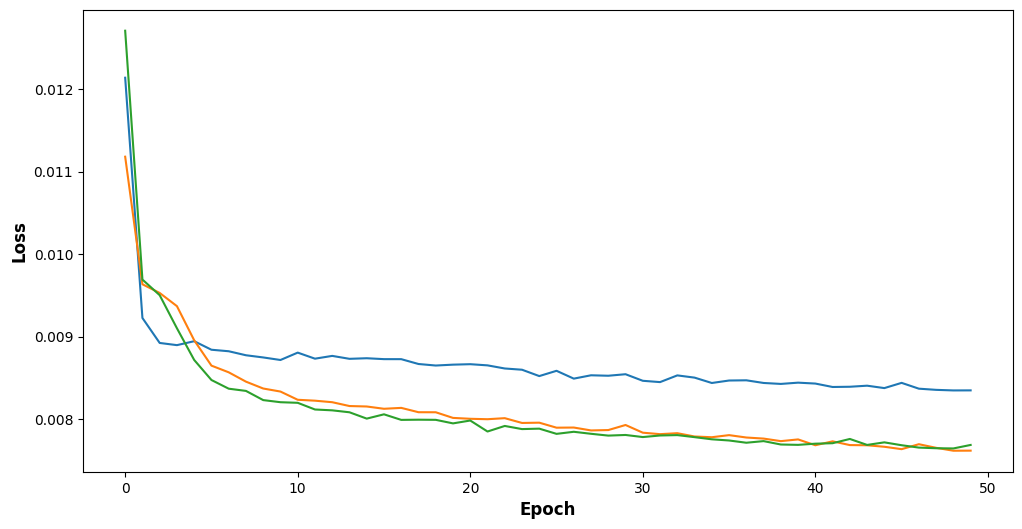

In [ ]:
# Step 7: Plot the change in loss function with each epoch for all methods
plt.figure(figsize=(12, 6))
for model_type in model_types:
    plt.plot(loss_histories[model_type], label=f'{model_type} Train Loss')
# plt.title('Training Loss RNN, GRU, and LSTM', fontsize=15)
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
# plt.legend()
plt.savefig('comparison.png', transparent=True)
plt.show()


RNN - Forecast vs Actual


216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


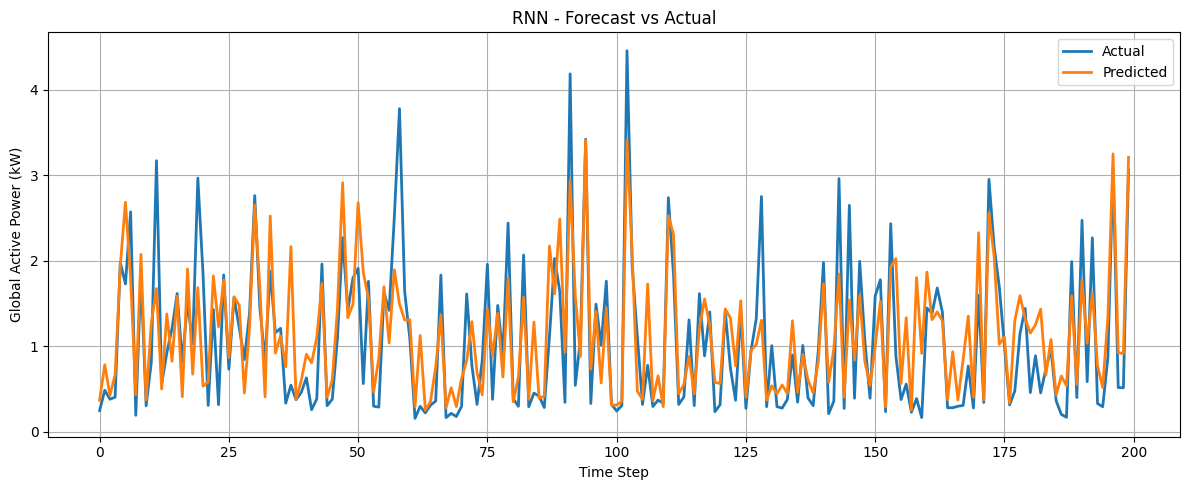


GRU - Forecast vs Actual
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


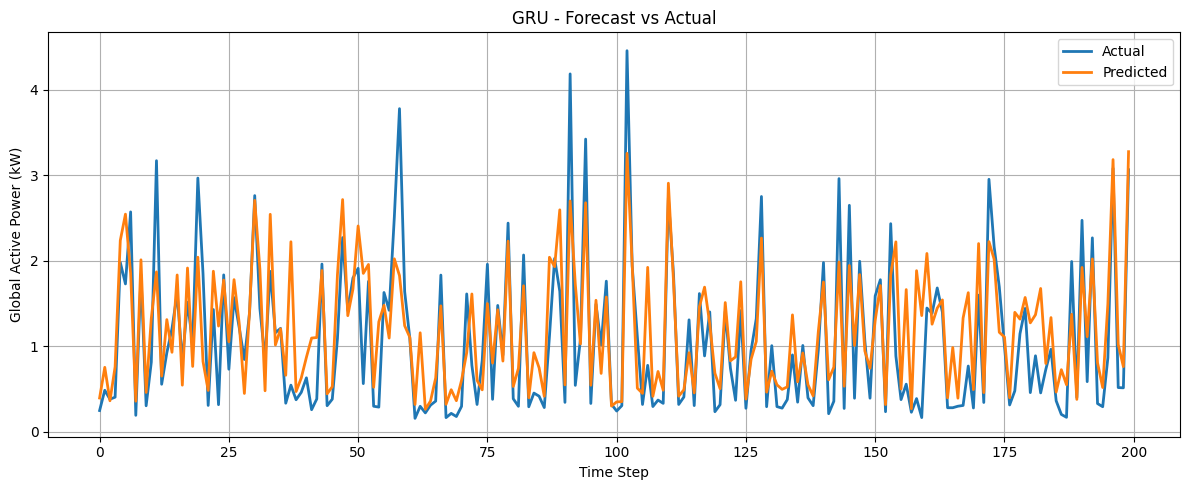


LSTM - Forecast vs Actual
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


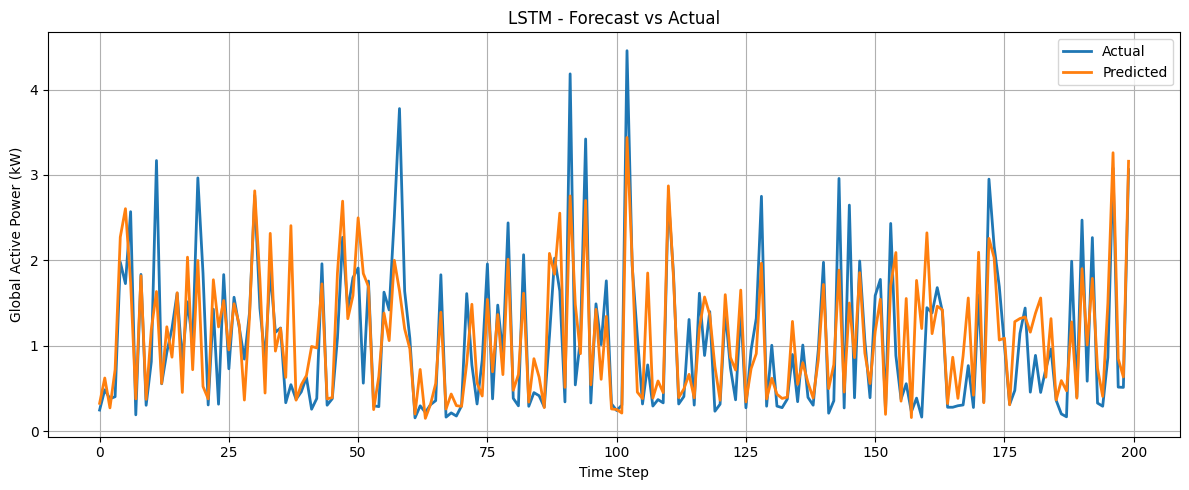


Performance Summary:
RNN: MAE=0.4081, RMSE=0.5787, R²=0.5843
GRU: MAE=0.4090, RMSE=0.5714, R²=0.5949
LSTM: MAE=0.3844, RMSE=0.5646, R²=0.6044


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

performance = {}

def inverse_transform(y_scaled):
    return scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

for model_type in model_types:
    print(f"\n{model_type} - Forecast vs Actual")

    model = trained_models[model_type]
    y_pred = model.predict(X_test)

    y_pred_inv = inverse_transform(y_pred)
    y_test_inv = inverse_transform(y_test)

    # Metrics
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    r2 = r2_score(y_test_inv, y_pred_inv)
    performance[model_type] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_inv[:200], label='Actual', linewidth=2)
    plt.plot(y_pred_inv[:200], label='Predicted', linewidth=2)
    plt.title(f'{model_type} - Forecast vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel('Global Active Power (kW)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Print metrics
print("\nPerformance Summary:")
for model_type, metrics in performance.items():
    print(f"{model_type}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}, R²={metrics['R2']:.4f}")
